# google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation & imports

In [ ]:
%pip install pydub

In [ ]:
import os
import librosa
from pydub import AudioSegment
import numpy as np
import scipy.signal
import shutil
import pickle
from pydub import AudioSegment
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# cleaning old windows

In [ ]:
def create_directory(output_directory):
  # Create the output directory if it doesn't exist
  if not os.path.exists(output_directory):
      os.makedirs(output_directory)
      for folder_name in folder_names:
        folder_path = os.path.join(output_directory, folder_name)
        os.makedirs(folder_path)
  # else:
  #     shutil.rmtree(output_directory)
  #     os.makedirs(output_directory)
  #     for folder_name in folder_names:
  #       folder_path = os.path.join(output_directory, folder_name)
  #       os.makedirs(folder_path)



# saving dataset as pickle

In [ ]:
def save_as_pickle(X_train, X_test, y_train, y_test, Y_data,
                   dataset_number, readme_file_path):
  pickle_dis = f"drive/MyDrive/DDEMS Lab/pickle_dataset/output{dataset_number}"
  # Create a folder to store the pickle files
  if not os.path.exists(pickle_dis):
      os.makedirs(pickle_dis)

  # Save X_train, X_test, y_train, y_test to pickle files in the data_folder
  with open(pickle_dis + '/X_train.pkl', 'wb') as f:
      pickle.dump(X_train, f)

  with open(pickle_dis + '/X_test.pkl', 'wb') as f:
      pickle.dump(X_test, f)

  with open(pickle_dis + '/y_train.pkl', 'wb') as f:
      pickle.dump(y_train, f)

  with open(pickle_dis + '/y_test.pkl', 'wb') as f:
      pickle.dump(y_test, f)

  with open(pickle_dis + '/Y_data.pkl', 'wb') as f:
      pickle.dump(Y_data, f)

  # Make a copy of the file : shutil.copy(source,destination)
  shutil.copy(readme_file_path, os.path.join(pickle_dis, 'README.md'))

# extracting windows

In [ ]:
def get_windows(window_duration = 3,    # Duration of each window in seconds
                overlap = 0,            # Amount of overlap between consecutive windows in seconds
                desired_sr = 22050,     # Set the desired sample rate (e.g., 22050 Hz)
                music_directories_list = ['drive/MyDrive/DDEMS Lab/Persian-Radif-Tar-Setar/cleaned/Setar-Hossein Alizzadeh-Mirza Abdullah',
                                          'drive/MyDrive/DDEMS Lab/Persian-Radif-Tar-Setar/cleaned/Tar-Arshad Tahmasebi-Mahmoud Karimi',
                                          'drive/MyDrive/DDEMS Lab/Persian-Radif-Tar-Setar/cleaned/Tar-Hossein Alizzadeh-Mirza Abdullah',
                                          ],
                dataset_number = "20", save_as_mp3=False
                ):

  pickle_dis = f"drive/MyDrive/DDEMS Lab/pickle_dataset/output{dataset_number}"

  create_directory(output_directory)

  X_data =[]
  Y_data =[]
  all_mp3_files = []
  window_counter = 0
  window_counter_temp = 0
  window_extracted_each = []
  gener_list_each = []

  for music_directory in music_directories_list:
    # Iterate over each folder in the music_directory
    number_files_in_album = 0
    print(music_directory)
    gener_list_each.append(os.listdir(music_directory))
    for foldername in os.listdir(music_directory):

        # if not foldername.endswith("output"):
        print(foldername)
        # Create the path to the current folder
        folder_path = os.path.join(music_directory, foldername)

        # Check if the current path is a directory
        if os.path.isdir(folder_path):
            # Create the output directory for the current folder
            avaz_dastgah = foldername
            output_directory_ = os.path.join(output_directory, avaz_dastgah)

            # Iterate over each file in the current folder
            for filename in os.listdir(folder_path):

                if filename.endswith('.mp3'):
                    number_files_in_album += 1
                    print("     -", filename)
                    filepath = os.path.join(folder_path, filename)
                    audio = AudioSegment.from_mp3(filepath)

                    # Convert audio to mono if it's in stereo
                    if audio.channels > 1:
                        audio = audio.set_channels(1)

                    # Resample the audio if necessary
                    if audio.frame_rate != desired_sr:
                        audio = audio.set_frame_rate(desired_sr)

                    # Convert the audio to a numpy array
                    audio_array = np.array(audio.get_array_of_samples())

                    # Calculate the number of samples for each window
                    window_size = int(window_duration * desired_sr)
                    hop_length = int((window_duration - overlap) * desired_sr)

                    # Extract windows from the audio
                    for i in range(0, len(audio_array) - window_size + 1, hop_length):

                        window = audio_array[i:i+window_size]
                        X_data.append(window)
                        Y_data.append(avaz_dastgah)
                        window_counter +=1

                        if save_as_mp3:
                          window_audio = AudioSegment(window.tobytes(), frame_rate=desired_sr, sample_width=2, channels=1)

                          # output_filename = f'window_{filename}_{i}_{i+window_size}_{avaz_dastgah}.mp3'
                          output_filename = f'window{window_counter}_{avaz_dastgah}.mp3'

                          output_path = os.path.join(output_directory_, output_filename)
                          window_audio.export(output_path, format='mp3')

    print("number of mp3 files : ", number_files_in_album)
    print("window size : ", window_duration, "overlap : ", overlap)
    print("number of windows extracted : ", window_counter - window_counter_temp)
    window_extracted_each.append(window_counter - window_counter_temp)
    window_counter_temp = window_counter
    all_mp3_files.append(number_files_in_album)


  # Create the content for the README file
  content = f"# data augmentation Details\n"
  content += "----------------------------------------------------------------\n"
  content += f"window size   : {window_duration}\n"
  content += f"overlap       : {overlap}\n"
  content += f"sampling rate : {desired_sr}\n"
  content += "----------------------------------------------------------------\n"
  content += f"geners ({len(folder_names)}): \n{folder_names}\n"
  content += f"number of all mp3 files         : {str(sum(all_mp3_files))}\n"
  content += f"number of all windows extracted : {str(sum(window_extracted_each))}\n"
  content += "----------------------------------------------------------------\n"
  for i, album in enumerate(music_directories_list):
    parts = album.split('/')
    # Get the last part of the string
    last_part = parts[-1]
    content += f"album : {last_part}\n"
    content += f"genres in album ({len(gener_list_each[i])}): \n{gener_list_each[i]}\n"
    content += f"number of mp3 files in album           : {str(all_mp3_files[i])}\n"
    content += f"number of windows extracted from album : {str(window_extracted_each[i])}\n"
    content += "----------------------------------------------------------------\n"

  # Path to the directory where the README file will be created
  readme_file_path = os.path.join(output_directory, 'README.md')

  # Write the content to the README file
  with open(readme_file_path, 'w') as file:
      file.write(content)

  print("README file created successfully!")
  del all_mp3_files, window_extracted_each, gener_list_each, content

  # Convert X and y to numpy arrays
  X_data = np.array(X_data)
  Y_data = np.array(Y_data)

  # Perform label encoding on the target labels
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(Y_data)

  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_encoded, test_size=0.2, random_state=42)
  del X_data, y_encoded

  #save dataset as pickle
  save_as_pickle(X_train, X_test, y_train, y_test, Y_data,
                 dataset_number, readme_file_path)

  return X_train, X_test, y_train, y_test, Y_data

# check the augmented files

In [ ]:
def check_augmented(output_directory):
  # Specify the path to the directory you want to count files in
  path = output_directory

  # Get a list of directories in the specified path
  directories = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

  # Loop through each directory and count the number of files
  count = 0
  for directory in directories:
      dir_path = os.path.join(path, directory)
      files_count = sum(1 for file in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file)))
      print(f"Number of files in {directory}: {files_count}")
      count += files_count
  print("counft : ", count)

# loading data from mp3 and train-test-split

In [ ]:
def load_mp3_windows_train_test(output_directory):

  # Set the directory path containing your windowed audio files
  window_directory = output_directory

  # Load the audio files and convert them to numpy arrays
  X = []
  y = []
  test = []
  # Loop through each folder in the directory
  for folder_name in os.listdir(window_directory):
      folder_path = os.path.join(window_directory, folder_name)
      if os.path.isdir(folder_path):
          # Loop through each windowed audio file in the folder
          for filename in os.listdir(folder_path):
              if filename.endswith('.mp3'):
                  # Load the audio file
                  filepath = os.path.join(folder_path, filename)
                  audio = AudioSegment.from_mp3(filepath)
                  # test.append(audio)
                  # Convert the audio to a numpy array
                  audio_array = np.array(audio.get_array_of_samples())

                  # Append the audio array to X
                  X.append(audio_array)

                  # Extract the label from the folder name
                  label = folder_name
                  y.append(label)

  # Convert X and y to numpy arrays
  X = np.array(X)
  y = np.array(y)

  # Perform label encoding on the target labels
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

  return X_train, X_test, y_train, y_test

# plot number of each class

In [ ]:
# print((np.unique(y_train, return_counts=True))[0], '\n', (np.unique(y_train, return_counts=True))[1])
# plt.bar(range(13), (np.unique(y_train, return_counts=True))[1])

In [ ]:
# print((np.unique(y_test, return_counts=True))[0], '\n', (np.unique(y_test, return_counts=True))[1])
# plt.bar(range(13), (np.unique(y_test, return_counts=True))[1])

# Mel-frequency cepstrum

## loading pickle files

In [ ]:
def load_pickle(dataset_number):
  pickle_dis = f"drive/MyDrive/DDEMS Lab/pickle_dataset/output{dataset_number}"

  # Load X_train, X_test, y_train, y_test from pickle files
  with open(pickle_dis + '/X_train.pkl', 'rb') as f:
      X_train = pickle.load(f)

  with open(pickle_dis + '/X_test.pkl', 'rb') as f:
      X_test = pickle.load(f)

  with open(pickle_dis + '/y_train.pkl', 'rb') as f:
      y_train = pickle.load(f)

  with open(pickle_dis + '/y_test.pkl', 'rb') as f:
      y_test = pickle.load(f)

  file_path = os.path.join(pickle_dis, "Y_data.pkl")
  if not os.path.exists(pickle_dis):
      concatenated_array = np.concatenate((y_train, y_test), axis=0)
      Y_data = concatenated_array
  else:
      with open(pickle_dis + '/Y_data.pkl', 'rb') as f:
        Y_data = pickle.load(f)

  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, Y_data.shape)
  return X_train, X_test, y_train, y_test, Y_data

# convert audio (numpy array) to mfccs


### Mel-frequency cepstrum
In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.


In [ ]:
def audio2mfccs(audio_data, sample_rate = 22050):

  # Number of MFCCs to compute
  num_mfccs = 13
  audio_data_float = audio_data.astype(np.float32)
  # List to store the MFCCs of each audio sample
  mfccs_list = []

  # Compute MFCCs for each audio sample in the dataset
  for audio_sample in audio_data_float:
      # Compute the MFCCs using librosa
      mfccs = librosa.feature.mfcc(y=audio_sample, sr=sample_rate, n_mfcc=num_mfccs)

      # Append the MFCCs to the list
      mfccs_list.append(mfccs)

  # Convert the list of MFCCs to a numpy array
  mfccs_array = np.array(mfccs_list)

  # Print the shape of the MFCCs array
  print("Shape of MFCCs array:", mfccs_array.shape)

  return mfccs_array

# plot MFCC

In [ ]:
def plot_MFCC(data):
  # Example: Plot the MFCCs of the first audio sample
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(data[0], x_axis='time')
  plt.colorbar()
  plt.title('MFCCs of Audio Sample 0')
  plt.xlabel('Time')
  plt.ylabel('MFCC Coefficients')
  plt.show()

# reshape input data

In [ ]:
def reshape_input(X_train_mfccs, X_test_mfccs):
  X_train_mfcc_reshaped = X_train_mfccs.reshape(X_train_mfccs.shape[0],
                                                X_train_mfccs.shape[1],
                                                X_train_mfccs.shape[2],
                                                1)

  X_test_mfcc_reshaped = X_test_mfccs.reshape(X_test_mfccs.shape[0],
                                              X_test_mfccs.shape[1],
                                              X_test_mfccs.shape[2],
                                              1)

  print(X_train_mfccs.shape , "reshaped input: ", X_train_mfcc_reshaped.shape)
  print(X_test_mfccs.shape ,  "reshaped input: ", X_test_mfcc_reshaped.shape)
  return X_train_mfcc_reshaped, X_test_mfcc_reshaped

The shape (2605, 13, 431) from librosa.feature.mfcc output means that you have
- 2605 audio samples
- 13 MFCC coefficients
- 431 frames in each audio sample.

The number 431 represents the **number of frames or time steps in the MFCCs**. The number of frames depends on :
- the size of the audio sample
- the window size
- the hop length used during the computation of the MFCCs.

Here's how the number of frames is calculated:

1. Calculate the duration of your audio samples in seconds. Since you have a window of 10 seconds and a sample rate of 22050 Hz, the number of samples in each audio sample would be 10 * 22050 = 220500.

2. To compute the number of frames in the MFCCs, you need to divide the number of audio samples by the hop length used in librosa.feature.mfcc. The hop length determines how much the sliding window advances at each step. The default value for hop_length in librosa.feature.mfcc is hop_length=512.

- Number of frames = (Number of samples - MFCC window size) / Hop length + 1
- Number of frames = (220500 - window_size) / 512 + 1
- Number of frames = (220500 - (sample_rate * window_duration)) / 512 + 1

You can use the n_fft and hop_length parameters in librosa.feature.mfcc to control the number of frames and the hop length. If you want to have a specific number of frames, you can adjust these parameters accordingly.

Keep in mind that the number of frames in the MFCCs depends on the audio sample's duration, the MFCC window size, and the hop length, which can vary for different applications.

# reshape output labels (bcs of cross entropy)

In [ ]:
def do_1hot_output(y_train, y_test):
  print(y_train.shape, y_test.shape)
  # Convert integer labels to one-hot encoded labels
  num_classes = 13  # Number of classes
  y_train_1hot = to_categorical(y_train, num_classes=num_classes)
  y_test_1hot = to_categorical(y_test, num_classes=num_classes)
  print("reshaped output: ",)
  print(y_train_1hot.shape, y_test_1hot.shape)
  return y_train_1hot, y_test_1hot

# saving filterd dataset as pickle

In [ ]:
def save_filterd_as_pickle(X_train_mfcc_reshaped, X_test_mfcc_reshaped,
                           y_train_1hot, y_test_1hot,
                           dataset_number, window_duration, overlap
                           ):

  pickle_dis = f"drive/MyDrive/DDEMS Lab/pickle_dataset/output{dataset_number}/filterd"

  # Create a folder to store the pickle files
  if not os.path.exists(pickle_dis):
      os.makedirs(pickle_dis)

  # Assuming you have X_train, X_test, y_train, y_test as numpy arrays

  # Save X_train, X_test, y_train, y_test to pickle files in the data_folder
  with open(pickle_dis + '/X_train_filterd.pkl', 'wb') as f:
      pickle.dump(X_train_mfcc_reshaped, f)

  with open(pickle_dis + '/X_test_filterd.pkl', 'wb') as f:
      pickle.dump(X_test_mfcc_reshaped, f)

  with open(pickle_dis + '/y_train_1hot.pkl', 'wb') as f:
      pickle.dump(y_train_1hot, f)

  with open(pickle_dis + '/y_test_1hot.pkl', 'wb') as f:
      pickle.dump(y_test_1hot, f)


  # Specify the path to the README-DATASETS.txt file
  readme_file_path = f"drive/MyDrive/DDEMS Lab/pickle_dataset/README-DATASETS.txt"

  # Strings to add to the README-DATASETS.txt file
  additional_content = f"""----------------------
  {dataset_number}
  window size   : {window_duration}
  overlap       : {overlap}"""

  # Read the existing content of the README-DATASETS.txt file
  with open(readme_file_path, 'r') as file:
      existing_content = file.read()

  # Combine the existing content and additional content
  new_content = existing_content + additional_content

  # Write the updated content back to the README-DATASETS.txt file
  with open(readme_file_path, 'w') as file:
      file.write(new_content)

  print("README-DATASETS.txt file updated successfully!")

# plot augmented data

In [ ]:
def plot_balance(Y_data):

  name = np.array(['A-Abuata', 'A-Afshari', 'A-Bayat-E Kord', 'A-Bayat-E Tork',
                   'A-Bayat-e Esfahan', 'A-Dashti', 'D-Chahargah', 'D-Homayun',
                   'D-Mahoor', 'D-Nava', 'D-Rastpanjgah', 'D-Segah', 'D-Shur'])

  price = (np.unique(Y_data, return_counts=True))[1]
  fig, ax = plt.subplots(figsize =(10, 7))

  # Horizontal Bar Plot
  ax.barh(name, price)

  # Remove axes splines
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)

  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)

  # Add x, y gridlines
  ax.grid( color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)

  # Show top values
  ax.invert_yaxis()

  # Add annotation to bars
  for i in ax.patches:
      plt.text(i.get_width()+0.2, i.get_y()+0.5,
              str(round((i.get_width()), 2)),
              fontsize = 10, fontweight ='bold',
              color ='grey')

  # Add Plot Title
  ax.set_title('albume genrs and their number',
              loc ='left', )

  # Show Plot
  plt.show()

# data augmentation

In [ ]:
def data_augmentation(train_data, train_labels, num_augmentations=4):

  # Lists to store augmented data and labels
  augmented_data = []
  augmented_labels = []

  # Data augmentation using random noise
  for sample, label in zip(train_data, train_labels):
      augmented_samples = [sample + np.random.normal(scale=0.01, size=sample.shape) for _ in range(num_augmentations)]
      augmented_labels.extend([label] * num_augmentations)  # Extend labels for augmented samples
      augmented_data.extend(augmented_samples)

  # Convert the lists of augmented data and labels back to NumPy arrays
  augmented_data = np.array(augmented_data)
  augmented_labels = np.array(augmented_labels)

  # Concatenate the original train data and labels with the augmented data and labels
  final_train_data = np.concatenate((train_data, augmented_data), axis=0)
  final_train_labels = np.concatenate((train_labels, augmented_labels), axis=0)

  # Now you have your final_train_data with augmented samples and the corresponding final_train_labels
  print(final_train_data.shape)
  print(final_train_labels.shape)

  return augmented_data, augmented_labels

# calling methods

In [ ]:
dataset_number =  "9"

music_directories_list = ['drive/MyDrive/DDEMS Lab/Persian-Radif-Tar-Setar/cleaned/Setar-Hossein Alizzadeh-Mirza Abdullah',
                          'drive/MyDrive/DDEMS Lab/Persian-Radif-Tar-Setar/cleaned/Tar-Arshad Tahmasebi-Mahmoud Karimi',
                          'drive/MyDrive/DDEMS Lab/Persian-Radif-Tar-Setar/cleaned/Tar-Hossein Alizzadeh-Mirza Abdullah',
                          ]
# music_directories_list = ['drive/MyDrive/DDEMS Lab/Persian-Radif-Tar-Setar/cleaned/Setar-Hossein Alizzadeh-Mirza Abdullah']
output_directory = f'drive/MyDrive/DDEMS Lab/Persian-Radif-Tar-Setar/augmented/output{dataset_number}'


folder_names = [ 'A-Abuata', 'A-Bayat-E Tork', 'D-Mahoor', 'D-Shur', 'A-Afshari',
                 'A-Dashti', 'D-Nava', 'A-Bayat-e Esfahan', 'D-Chahargah', 'D-Rastpanjgah',
                 'A-Bayat-E Kord', 'D-Homayun', 'D-Segah']

window_duration = 5  # Duration of each window in seconds
overlap = 0           # Amount of overlap between consecutive windows in seconds
desired_sr = 22050    # Set the desired sample rate (e.g., 22050 Hz)

# X_train, X_test, y_train, y_test, Y_data = get_windows(window_duration = window_duration,
#                                                        overlap = overlap,
#                                                desired_sr = desired_sr,
#                                                music_directories_list= music_directories_list,
#                                                dataset_number = dataset_number,
#                                                save_as_mp3=False
#                                                )

X_train, X_test, y_train, y_test, Y_data = load_pickle(dataset_number)

(7725, 110250) (1932, 110250) (7725,) (1932,) (9657,)


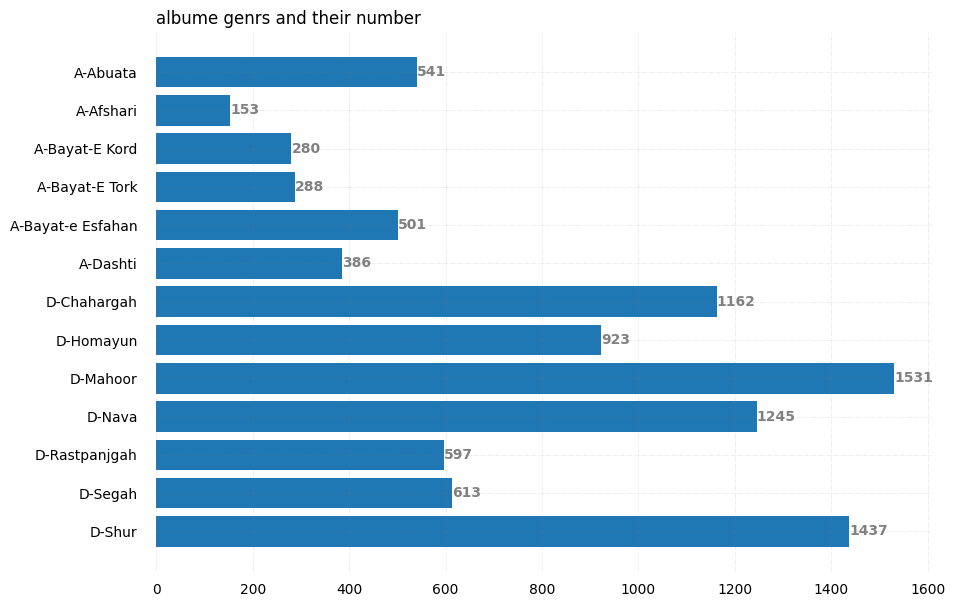

In [ ]:
plot_balance(Y_data)

In [ ]:

X_train_aug, y_train_aug= data_augmentation(X_train, y_train,num_augmentations=6)

In [ ]:
plot_balance(y_train_aug)

In [ ]:
X_test_mfccs = audio2mfccs(X_test)
del X_test
X_train_mfccs = audio2mfccs(X_train)
del X_train

Shape of MFCCs array: (1932, 13, 216)
Shape of MFCCs array: (7725, 13, 216)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12] 
 [ 541  153  280  288  501  386 1162  923 1531 1245  597  613 1437]
data counter :  10


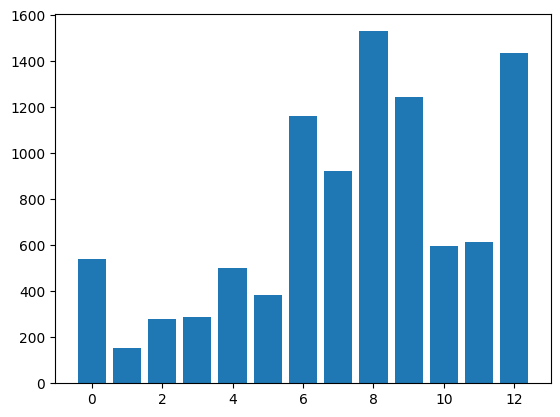

In [ ]:
# check_augmented(output_directory)
concatenated_array = np.concatenate((y_train, y_test))
print((np.unique(concatenated_array, return_counts=True))[0], '\n', (np.unique(concatenated_array, return_counts=True))[1])
plt.bar(range(13), (np.unique(concatenated_array, return_counts=True))[1])
print("data counter : ", concatenated_array[0])

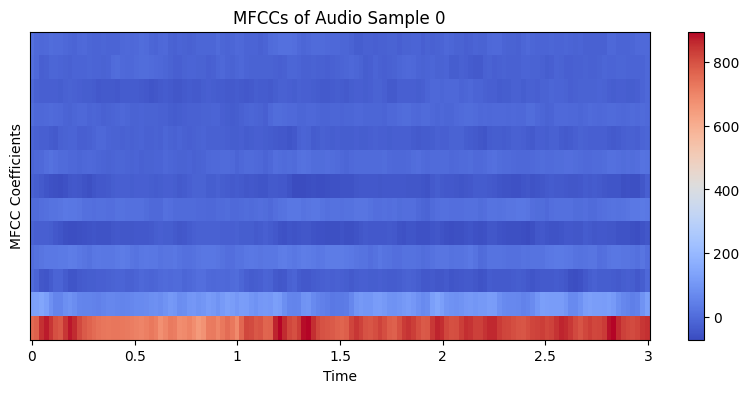

In [ ]:
plot_MFCC(X_train_mfccs)

In [ ]:
X_train_mfcc_reshaped, X_test_mfcc_reshaped = reshape_input(X_train_mfccs, X_test_mfccs)
y_train_1hot, y_test_1hot = do_1hot_output(y_train, y_test)

(7725, 13, 216) reshaped input:  (7725, 13, 216, 1)
(1932, 13, 216) reshaped input:  (1932, 13, 216, 1)
(7725,) (1932,)
reshaped output: 
(7725, 13) (1932, 13)


In [ ]:
save_filterd_as_pickle(X_train_mfcc_reshaped, X_test_mfcc_reshaped,
                       y_train_1hot, y_test_1hot, dataset_number, window_duration, overlap
                       )

README-DATASETS.txt file updated successfully!
